<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/ignore.preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2021-05-03 21:42:20--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.2’

visualization.py.2  100%[===================>]  12.70K  --.-KB/s    in 0s      

2021-05-03 21:42:20 (107 MB/s) - ‘visualization.py.2’ saved [13008/13008]



### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [ ]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


# Use case description

The use case is from [ComCom19].


**Goal** Estimate bandwidth available between two communicating endpoints.
![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/train-of-packets.png)

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.



Measures
* Bits per seconds sent $r_{\text{in}}$
* Bits per second received $r_\text{out}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/r_in-r_out.png)
\[Figure from [ComCom19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))



# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [ ]:
!wget http://www-public.imtbs-tsp.eu/~araldo/pmwiki/uploads/datasets/BandwidthEstimationTraces.zip

--2021-05-03 21:42:21--  http://www-public.imtbs-tsp.eu/~araldo/pmwiki/uploads/datasets/BandwidthEstimationTraces.zip
Resolving www-public.imtbs-tsp.eu (www-public.imtbs-tsp.eu)... 157.159.10.118
Connecting to www-public.imtbs-tsp.eu (www-public.imtbs-tsp.eu)|157.159.10.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1119200 (1.1M) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip.2’

BandwidthEstimation 100%[===================>]   1.07M  1.71MB/s    in 0.6s    

2021-05-03 21:42:22 (1.71 MB/s) - ‘BandwidthEstimationTraces.zip.2’ saved [1119200/1119200]



In [ ]:
! unzip -o -q BandwidthEstimationTraces.zip

In [ ]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [ ]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server.

In [ ]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [ ]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [ ]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* 1st column: ratio $r_\text{in} / r_\text{out}$
* 2nd column: Some sort of time stamp that we will ignore (not well described in the dataset)



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/r_in-r_out.png)
\[Figure from [ComCom19] \]


Let's rename the columns to avoid ambiguity

In [ ]:
df.columns=['ratio', 'timestamp']
df.head()

,ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

(array([2.46797799, 1.23398899, 0.6169945 , 1.23398899, 1.23398899,
        1.23398899, 1.23398899, 0.6169945 , 0.6169945 , 1.85098349]),
 array([0.99982 , 1.080858, 1.161896, 1.242934, 1.323972, 1.40501 ,
        1.486048, 1.567086, 1.648124, 1.729162, 1.8102  ]),
 <a list of 10 Patch objects>)

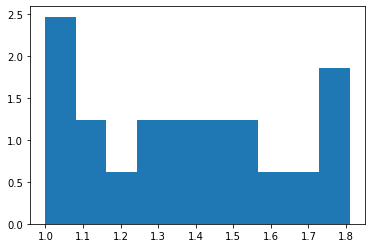

In [ ]:
plt.hist(df['ratio'], density=True)

# density:  True garantees that the area is 1 (such that the histogram
#     approximates a probability density function)

The histogram above is just our sample, describing an experiment, which is a sequence of measures. In this case, the histogram above is telling us that most of the time a ratio between 1.00 and 1.05 has been measured; also values of ratio between 1.75 and 1.80 have been measured many times.

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Open all files
* Take the min and max ratio from all the experiments
* Divide the [min,max] interval uniformly

In [ ]:
def get_all_csv_files(folder):
  """
  Credits to https://perials.com/getting-csv-files-directory-subdirectories-using-python/

  Returns all the csv files within the folder, and all subfolders
  """
  import os
  from glob import glob
  PATH = "/home/someuser/projects/someproject"
  EXT = "*.csv"
  all_csv_files = [file
                  for path, subdir, files in os.walk(folder)
                  for file in glob(os.path.join(path, "*.csv"))]
  return all_csv_files

To avoid data leaks, we compute the max and the min on the training set only.

In [ ]:
train_files = get_all_csv_files('BandwidthEstimationTraces/training')
print('Found ', len(train_files), ' training files' )

Found  1100  training files


Find the min and max

In [ ]:
min_ratio = float('inf')
max_ratio = 0

for filename in train_files:
      df = pd.read_csv(filename)
      df.columns=['ratio', 'timestamp']
      trace_min = min( df['ratio'] )
      trace_max = max( df['ratio'] )
      min_ratio = min ( [ min_ratio, trace_min ] )
      max_ratio = max ( [ max_ratio, trace_max ] )

print('min_ratio:', min_ratio, ' max_ratio:',max_ratio)

min_ratio: 0.95975  max_ratio: 2.318


Let's create the bins that we will use for all experiments

In [ ]:
N = 8 # num of bins

bin_size = (max_ratio-min_ratio)/N
bins = [min_ratio + i * bin_size for i in range(0, N+1)]
bins

[0.95975,
 1.1295312499999999,
 1.2993125,
 1.4690937499999999,
 1.638875,
 1.8086562499999999,
 1.9784375,
 2.14821875,
 2.318]

Just as a visual check, let's plot again the previous histogram with these new bins

[1.76697957 0.88348978 1.17798638 0.88348978 0.88348978 0.29449659
 0.         0.        ]


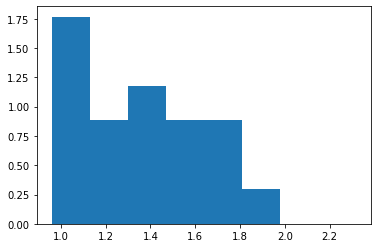

In [ ]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df.columns=['ratio', 'timestamp']
hist_values, bins, bars = plt.hist( df['ratio'], density=True, bins=bins)
print(hist_values )

As specified previously, this histogram is a sample for us. In particular, this sample is the vector

  `[1.77 0.89 1.18 0.89 0.89 0.29 0 0]`

Let's obtain the histogram for all the experiments. For each experiment, the corresponding sample is a vector in the following form:

  `[bin1_freq, bin2_freq, ...., binN_freq]`

and a label `avail_bandwidth`.

We write these operations in a function `construct_dataset` that we will then use for the training and the test dataset.

This is to avoid **copied and pasted code**, which is prone to error.

In [ ]:
def process_file(filename, bins):
      """
      For the connection described in filename, it
      returns a feature vector and the available bandwidth
      """
      df = pd.read_csv(filename)

      # Observe that for each experiment, the available bandwidth corresponds
      # to the name of the second column
      avail_band = df.columns[1]


      df.columns=['ratio', 'timestamp']

      histogram_values, bins, bars = plt.hist( df['ratio'], density=True,
                                              bins=bins)

      return histogram_values, avail_band



def construct_dataset(files, bins):
  """
  Build an X,y from the files
  """

  X = np.empty((0,N), int)
  label = []

  for filename in files:
      histogram_values, avail_band = process_file(filename, bins)

      X = np.vstack(( X, histogram_values) )
      label.append(avail_band)

  return X,label

Found  1000  test files


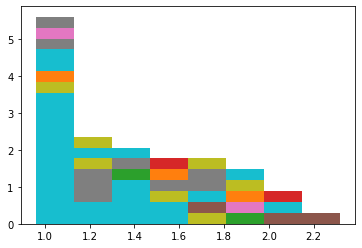

In [ ]:
X_train_raw, label_train_raw = construct_dataset(train_files, bins)

test_files = get_all_csv_files('BandwidthEstimationTraces/testing')
print ('Found ', len(test_files), ' test files'  )

X_test, label_test = construct_dataset(test_files, bins)

In [ ]:
print('X_train\n', X_train_raw[0:6, :] )
print('\n\nlabel_train\n',label_train_raw )

X_train
 [[2.94496595 1.17798638 0.88348978 0.58899319 0.29449659 0.
  0.         0.        ]
 [2.65046935 1.76697957 0.88348978 0.58899319 0.         0.
  0.         0.        ]
 [2.94496595 1.17798638 1.17798638 0.58899319 0.         0.
  0.         0.        ]
 [2.94496595 1.47248297 0.88348978 0.         0.58899319 0.
  0.         0.        ]
 [3.53395914 0.58899319 0.88348978 0.88348978 0.         0.
  0.         0.        ]
 [2.94496595 1.47248297 0.88348978 0.58899319 0.         0.
  0.         0.        ]]


label_train
 ['25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '2

In [ ]:
sample_size = X_train_raw.shape[1]
print('The sample size is ', sample_size,
      ', which should correspond to the number of bins ', N)

The sample size is  8 , which should correspond to the number of bins  8
